In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Importar librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


%matplotlib inline

In [21]:
df_origin = pd.read_csv('https://raw.githubusercontent.com/jfelipeo/Proyecto_Analitica_II_Equipo-5/main/ecommerce-data.csv', sep=",")
df_transformed = df_origin.copy()

In [22]:
df_transformed = df_transformed.drop_duplicates()

In [23]:
df_transformed[['OperatingSystems', 'Browser', 'Region', 'TrafficType']] = df_transformed[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype('object')
df_transformed[['Reviews','Informational','ProductRelated']] = df_transformed[['Reviews','Informational','ProductRelated']].astype('float')

In [24]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Reviews                  12205 non-null  float64
 1   Reviews_Duration         12205 non-null  float64
 2   Informational            12205 non-null  float64
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  float64
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  object 
 12  Browser                  12205 non-null  object 
 13  Region                   12205 non-null  object 
 14  TrafficType              12

In [26]:
cols_delete = ['Reviews_Duration', 'Informational_Duration','ProductRelated_Duration']
df_depured= df_transformed.drop(cols_delete, axis=1)
df_depured.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Reviews           12205 non-null  float64
 1   Informational     12205 non-null  float64
 2   ProductRelated    12205 non-null  float64
 3   BounceRates       12205 non-null  float64
 4   ExitRates         12205 non-null  float64
 5   PageValues        12205 non-null  float64
 6   SpecialDay        12205 non-null  float64
 7   Month             12205 non-null  object 
 8   OperatingSystems  12205 non-null  object 
 9   Browser           12205 non-null  object 
 10  Region            12205 non-null  object 
 11  TrafficType       12205 non-null  object 
 12  VisitorType       12205 non-null  object 
 13  Weekend           12205 non-null  bool   
 14  Purchase          12205 non-null  bool   
dtypes: bool(2), float64(7), object(6)
memory usage: 1.3+ MB


In [27]:
df_depured.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Reviews,12205.0,2.338878,3.330436,0.0,0.000000,1.000000,4.000000,27.000000
Informational,12205.0,0.508726,1.275617,0.0,0.000000,0.000000,0.000000,24.000000
ProductRelated,12205.0,32.045637,44.593649,0.0,8.000000,18.000000,38.000000,705.000000
BounceRates,12205.0,0.020370,0.045255,0.0,0.000000,0.002899,0.016667,0.200000
ExitRates,12205.0,0.041466,0.046163,0.0,0.014231,0.025000,0.048529,0.200000
PageValues,12205.0,5.949574,18.653671,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12205.0,0.061942,0.199666,0.0,0.000000,0.000000,0.000000,1.000000


Revisión de los datos atípicos extremos

In [28]:
# Diccionario de valores límite para cada columna
valores_limite = {'Reviews': 25, 'Informational': 15, 'ProductRelated': 450, 'BounceRates':0.2, 'ExitRates': 0.2, 'PageValues': 150}

# Conteo de datos
conteos = {}

# Iteraracion y busqueda
for columna, limite in valores_limite.items():
    # Filtrar los datos de la columna que sean mayores o iguales al valor límite
    datos_filtrados = df_depured[df_depured[columna] >= limite][columna]
    # Contar el número de filas encontradas
    conteo = datos_filtrados.count()
    # Almacenar el conteo en el diccionario
    conteos[columna] = conteo

# Mostrar los conteos para cada columna
for columna, conteo in conteos.items():
    print("Datos mayores o iguales a", valores_limite[columna], "en la columna", columna + ":", conteo)

Datos mayores o iguales a 25 en la columna Reviews: 2
Datos mayores o iguales a 15 en la columna Informational: 2
Datos mayores o iguales a 450 en la columna ProductRelated: 9
Datos mayores o iguales a 0.2 en la columna BounceRates: 575
Datos mayores o iguales a 0.2 en la columna ExitRates: 585
Datos mayores o iguales a 150 en la columna PageValues: 27


## Prueba transformando atípicos extremos

In [107]:
columnas_numericas = df_depured.select_dtypes(include=np.number)
medianas = columnas_numericas.median()

# Iterar sobre las columnas y valores límite
for columna, limite in valores_limite.items():
    # Filtrar los datos de la columna que sean mayores o iguales al valor límite
    indices_filtrados = df_depured[columna] >= limite
    # Reemplazar los valores que cumplen la condición por la mediana de esa columna
    df_depured.loc[indices_filtrados, columna] = medianas[columna]

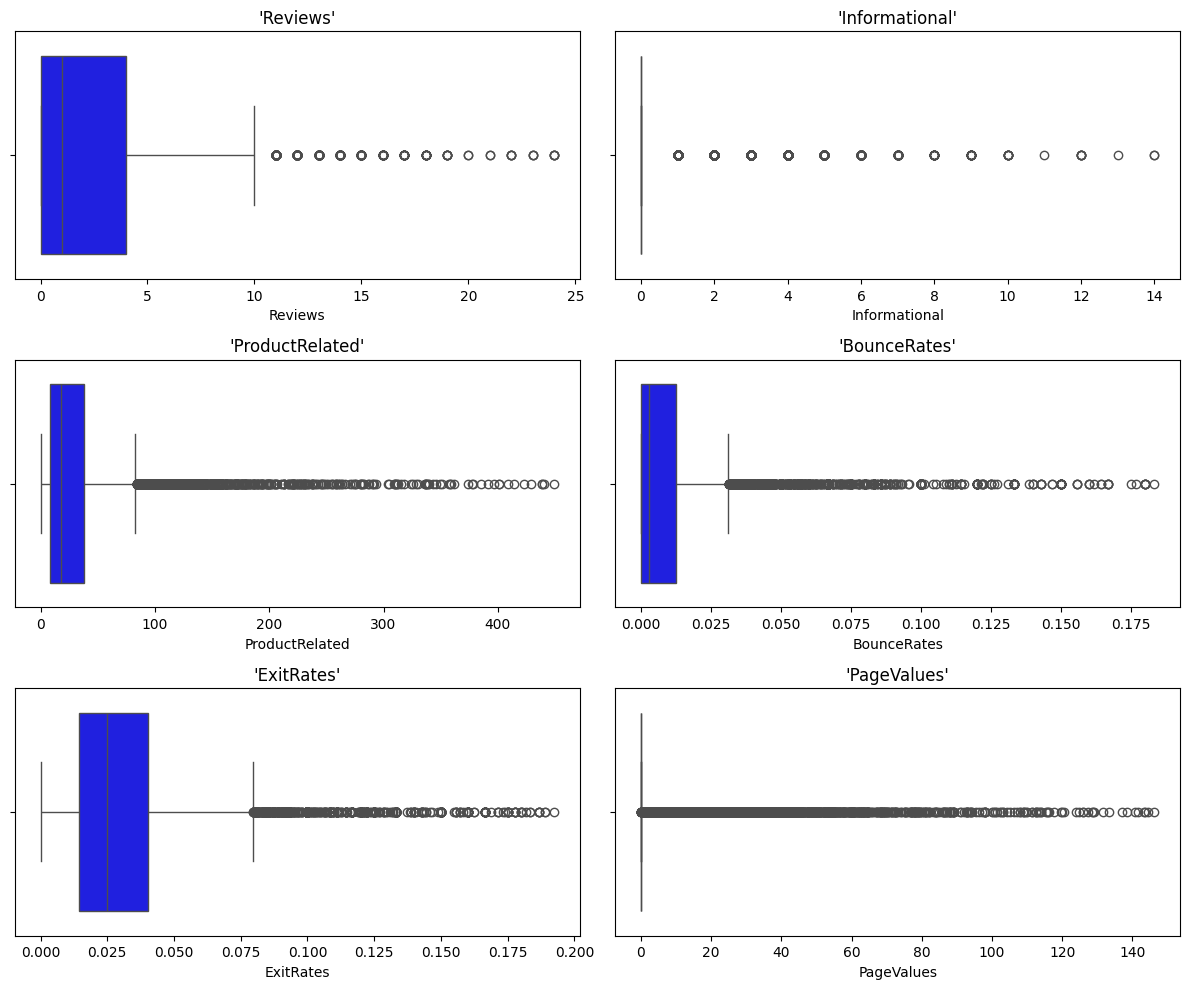

In [122]:
variables_numericas = ['Reviews', 'Informational', 'ProductRelated',
                       'BounceRates',
                       'ExitRates', 'PageValues']

num_variables = len(variables_numericas)
num_filas = (num_variables + 1) // 2
num_columnas = 2

fig, axes = plt.subplots(num_filas, num_columnas, figsize=(12, 10))
axes = axes.flatten()

for i, variable in enumerate(variables_numericas):
    sns.boxplot(x=df_depured[variable], ax=axes[i], color='Blue')
    axes[i].set_title(f"'{variable}'")
    #axes[i].set_xlabel()

plt.tight_layout()
plt.show()

## Separación de variable objetivo y caracteristicas

In [29]:
y = df_depured.Purchase
X = df_depured.drop(['Purchase'], axis=1)

In [30]:
X_dummys = pd.get_dummies(X)
X_dummys.head()

,Reviews,Informational,ProductRelated,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month_Aug,Month_Dec,...,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0.0,0.0,1.0,0.20,0.20,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,0.0,0.0,2.0,0.00,0.10,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0.0,0.0,1.0,0.20,0.20,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0.0,0.0,2.0,0.05,0.14,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.0,0.0,10.0,0.02,0.05,0.0,0.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [31]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

print(y[:10])
print(le.classes_)

[0 0 0 0 0 0 0 0 0 0]
[False  True]


## Selección de variables por el metodo de Wrapper

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Función recursiva de selección de características
def recursive_feature_selection(X,y,model,k):
  rfe = RFE(model, n_features_to_select=k, step=1)
  fit = rfe.fit(X, y)
  X_new = fit.support_
  print("Num Features: %s" % (fit.n_features_))
  print("Selected Features: %s" % (fit.support_))
  print("Feature Ranking: %s" % (fit.ranking_))

  return X_new

In [71]:
# Establecer Estimador
model = LogisticRegression(max_iter=300)
# Obtener columnas seleciconadas - (10 caracteristicas)
X_new_class = recursive_feature_selection(X_dummys, y, model, 10)
# Nuevo conjunto de datos
df_classification_new = X_dummys.iloc[:,X_new_class]
df_classification_new.head()

Num Features: 10
Selected Features: [False False False  True  True False  True False False False  True False
 False False False  True False False False False False False False False
 False False False False  True False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
  True False  True False False  True False False False False False]
Feature Ranking: [52 31 62  1  1 39  1 35  6 22  1  8 29 16 38  1  4  5 45 20  9 46 44 21
 18 23 30 27  1 28 61 19 17 48 53 40 43  1 42 58 25 50 41 37 55 49 60 24
  3 33  2 57 36 12  7 15 56 32 34 51  1 47  1 13 54  1 10 11 59 26 14]


,BounceRates,ExitRates,SpecialDay,Month_Feb,Month_Nov,Browser_3,Browser_12,TrafficType_13,TrafficType_15,TrafficType_18
0,0.20,0.20,0.0,True,False,False,False,False,False,False
1,0.00,0.10,0.0,True,False,False,False,False,False,False
2,0.20,0.20,0.0,True,False,False,False,False,False,False
3,0.05,0.14,0.0,True,False,False,False,False,False,False
4,0.02,0.05,0.0,True,False,True,False,False,False,False


In [72]:
from sklearn.feature_selection import SequentialFeatureSelector

# Selector secuencias utilizando regresión logistica - clasificación
sfs = SequentialFeatureSelector(LogisticRegression(max_iter=300),
                                n_features_to_select=5,
                                direction= "forward",
                                scoring='recall')

# Obtener variable seleccionadas
sfs = sfs.fit(X_dummys, y)
X_new_class = sfs.support_
df_classification_new = X_dummys.iloc[:,X_new_class]
df_classification_new.head()

,PageValues,Month_Dec,Month_Mar,Month_May,VisitorType_New_Visitor
0,0.0,False,False,False,False
1,0.0,False,False,False,False
2,0.0,False,False,False,False
3,0.0,False,False,False,False
4,0.0,False,False,False,False


# Desbalanceo de Clases

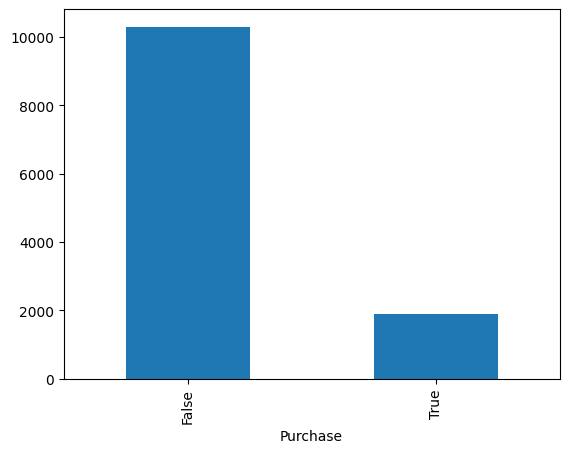

In [14]:
# Identificación de ejemplos de entrenamiento por clases
df_depured['Purchase'].value_counts().plot(kind='bar');



Por tratarse de un desbalanceo, vamos a realizar el submuestreo aleatorio con imblearn

In [36]:
# importar libreria
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

sub = RandomUnderSampler(random_state=42) 
# fit predictor and target variable
###X_sub, y_sub = sub.fit_resample(X_dummys, y)
X_sub, y_sub = sub.fit_resample(df_classification_new, y)
print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_sub))

original dataset shape: Counter({0: 10297, 1: 1908})
Resample dataset shape Counter({0: 1908, 1: 1908})


O por sobremuestreo

In [54]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=42)

# # fit predictor and target variablex_ros, y_ros = ros.fit_resample(x, y)
# X_sub, y_sub = ros.fit_resample(X_dummys, y)

# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_sub))

Original dataset shape Counter({0: 10297, 1: 1908})
Resample dataset shape Counter({0: 10297, 1: 10297})


# Modelado: Aplicación de técnicas de ML

## Modelo 1: Decision Tree Classifier



In [41]:

# split de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(df_classification_new, y, test_size=0.2,random_state=0)

In [42]:
# Entrenamiento del modelo

clf = tree.DecisionTreeClassifier(
          criterion = 'gini',
          max_depth = 6,
          max_leaf_nodes=10,
          random_state=0, 
          #class_weight='balanced'
          )
clf.fit(X_sub, y_sub)
#clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10, random_state=0)

### Metricas de desempeño

In [43]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, clf.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, clf.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, clf.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, clf.predict(X_test), digits=4))


Train - Accuracy : 0.8719786972552233
Train - classification report:
               precision    recall  f1-score   support

           0     0.9621    0.8829    0.9208      8234
           1     0.5634    0.8131    0.6656      1530

    accuracy                         0.8720      9764
   macro avg     0.7628    0.8480    0.7932      9764
weighted avg     0.8997    0.8720    0.8808      9764

Test - Accuracy : 0.8721835313396149
Test - classification report:
               precision    recall  f1-score   support

           0     0.9562    0.8895    0.9216      2063
           1     0.5632    0.7778    0.6533       378

    accuracy                         0.8722      2441
   macro avg     0.7597    0.8336    0.7875      2441
weighted avg     0.8954    0.8722    0.8801      2441



Analisis:
* Accuracy (Precisión): El accuracy es una medida de qué tan bien el modelo clasifica correctamente las muestras. En el conjunto de entrenamiento, el accuracy es del 84.72% y en el conjunto de prueba es del 85.33%. Estos valores son similares, lo que sugiere que el modelo no está sobreajustando o subajustando demasiado los datos de entrenamiento.

* Precision (Precisión): La precisión se refiere a la proporción de instancias clasificadas como positivas que son verdaderamente positivas. En el conjunto de entrenamiento, la precisión para la clase 0 es del 97.31% y para la clase 1 es del 50.60%. En el conjunto de prueba, la precisión para la clase 0 es del 96.92% y para la clase 1 es del 51.60%. Esto indica que el modelo tiene una alta precisión para la clase mayoritaria (0) pero una precisión más baja para la clase minoritaria (1).

* Recall (Sensibilidad): El recall se refiere a la proporción de instancias positivas que fueron correctamente identificadas por el modelo. En el conjunto de entrenamiento, el recall para la clase 0 es del 84.21% y para la clase 1 es del 87.45%. En el conjunto de prueba, el recall para la clase 0 es del 85.36% y para la clase 1 es del 85.19%. Esto indica que el modelo tiene una buena capacidad para identificar correctamente las instancias positivas en ambas clases.

* F1-score (Puntaje F1): El puntaje F1 es la media armónica de precisión y recall. Es útil cuando tienes un desequilibrio en las clases. En el conjunto de entrenamiento, el puntaje F1 para la clase 0 es del 90.29% y para la clase 1 es del 64.20%. En el conjunto de prueba, el puntaje F1 para la clase 0 es del 90.77% y para la clase 1 es del 64.27%. Estos valores combinan la precisión y el recall para proporcionar una medida única de rendimiento

Finalmente, se concluye que parace tener buenos rendimientos en terminos de precision y recall en ambos conjuntos de datos. En contraste, se ve una diferencia notable en la precision entre las caracteristicas de la variable objetivo, donde el modelo puede presentar dificultades para predicir la clase minoritaria, es decir para predecir los valores verdaderos (1). **Lo anterior es sin haber tratado los outliers y sin selección de variables.**

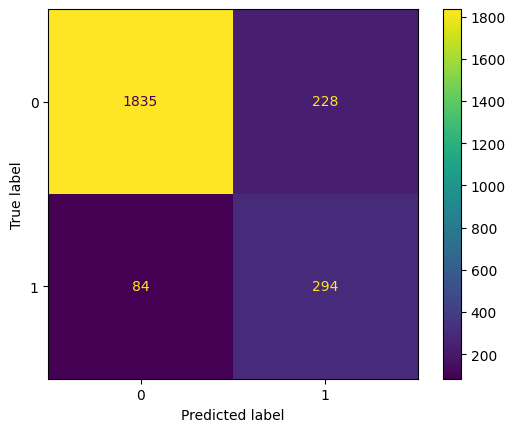

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm= confusion_matrix(y_test, clf.predict(X_test))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

Profundidad del árbol: 5
Número de nodos terminales: 10


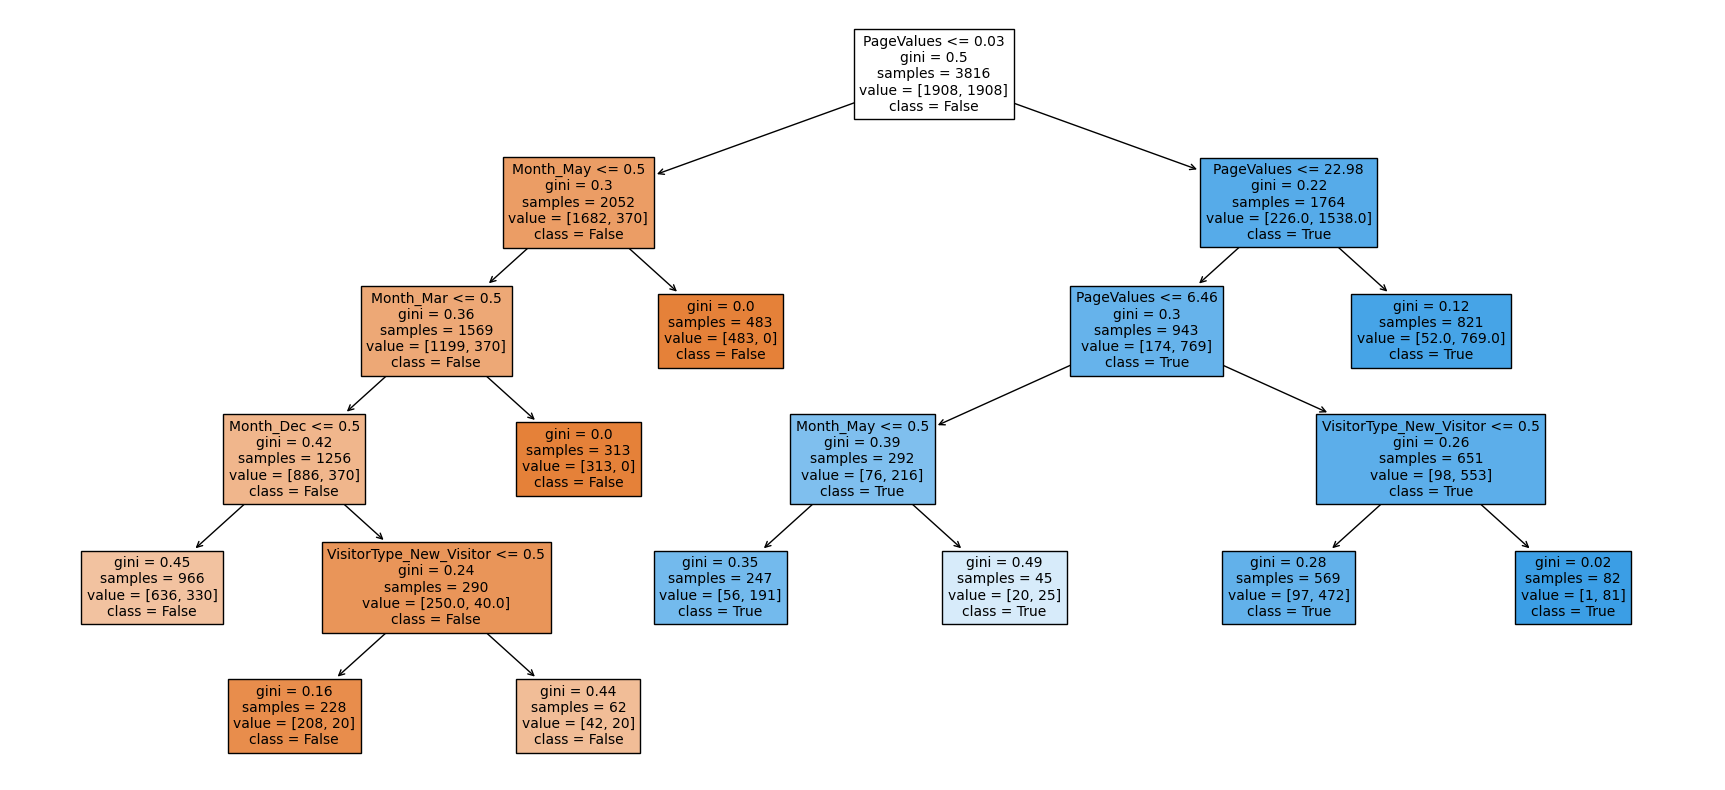

In [45]:
# Visualización del arbol

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(22, 10))

print(f"Profundidad del árbol: {clf.get_depth()}")
print(f"Número de nodos terminales: {clf.get_n_leaves()}")

plot = plot_tree(
            decision_tree = clf,
            feature_names = df_classification_new.columns.tolist(),
            class_names   = ['False', 'True'],
            filled        = True,
            impurity      = True,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

# Modelo 2: Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier
# Entrenamiento del modelo

ranfor = RandomForestClassifier(
            n_estimators = 150,
            criterion    = 'gini',
            max_depth    = 6,
            max_leaf_nodes = 10,
            n_jobs       = -1,
            random_state = 123,
            #class_weight = 'balanced'
         )
ranfor.fit(X_sub, y_sub)
#ranfor.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_leaf_nodes=10, n_estimators=150,
                       n_jobs=-1, random_state=123)

In [47]:
# Métricas de desempeño

print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, ranfor.predict(X_test)))

Train - Accuracy : 0.8748463744367063
Train - classification report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      8234
           1       0.57      0.81      0.67      1530

    accuracy                           0.87      9764
   macro avg       0.77      0.85      0.80      9764
weighted avg       0.90      0.87      0.88      9764

Test - Accuracy : 0.8742318721835314
Test - classification report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      2063
           1       0.57      0.78      0.66       378

    accuracy                           0.87      2441
   macro avg       0.76      0.83      0.79      2441
weighted avg       0.90      0.87      0.88      2441



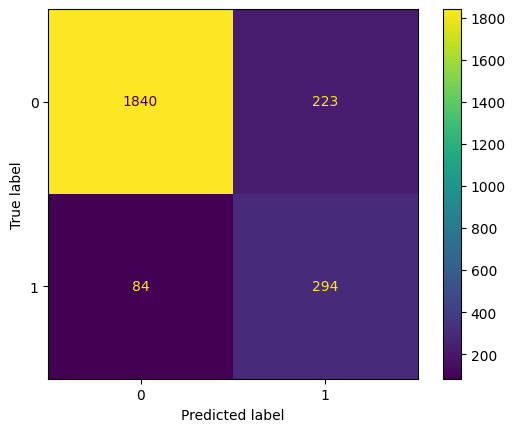

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm1= confusion_matrix(y_test, ranfor.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

# Modelo 3: Tunning de Hiperparámetros

## RandomForest

In [50]:
# Importe de libreria
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [51]:
## Definir cuadricula de búsqueda
# =================================================
parameters = {
    'max_depth': [None,5,10,15,20],
    'max_features': [0.6, 0.8, 1],
    'max_leaf_nodes': [6,8,10,12,14],
    'min_samples_leaf': [6,8,10,12,14],
    'n_estimators': [100,150,200,250,300]
}

In [52]:
# Modelo para tunning
ranfor_s = RandomForestClassifier(
    criterion = 'gini',
    n_jobs = -1,
    random_state= 123,
    #class_weight = 'balanced'
)

In [53]:
# Búsqueda aleatoria

# Definición de cuadricula de búsqueda
rand_s = RandomizedSearchCV(ranfor_s, param_distributions=parameters, n_iter=20, scoring='roc_auc', cv=5, verbose=True)

# Iniciar la búsqueda
rand_s.fit(X_sub, y_sub)
#rand_s.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=123),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20],
                                        'max_features': [0.6, 0.8, 1],
                                        'max_leaf_nodes': [6, 8, 10, 12, 14],
                                        'min_samples_leaf': [6, 8, 10, 12, 14],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   scoring='roc_auc', verbose=True)

In [54]:
print('Mejores Hiperparámetros: ', rand_s.best_params_)
print('Mejor Score: ', rand_s.best_score_)

Mejores Hiperparámetros:  {'n_estimators': 250, 'min_samples_leaf': 14, 'max_leaf_nodes': 14, 'max_features': 0.8, 'max_depth': None}
Mejor Score:  0.9038927141522128


In [55]:
# Métricas de desempeño
ranfor_optimo = rand_s.best_estimator_
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor_optimo.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor_optimo.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor_optimo.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, ranfor_optimo.predict(X_test)))

Train - Accuracy : 0.8731052847193773
Train - classification report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      8234
           1       0.57      0.81      0.67      1530

    accuracy                           0.87      9764
   macro avg       0.76      0.85      0.79      9764
weighted avg       0.90      0.87      0.88      9764

Test - Accuracy : 0.8730028676771815
Test - classification report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      2063
           1       0.57      0.78      0.65       378

    accuracy                           0.87      2441
   macro avg       0.76      0.83      0.79      2441
weighted avg       0.90      0.87      0.88      2441



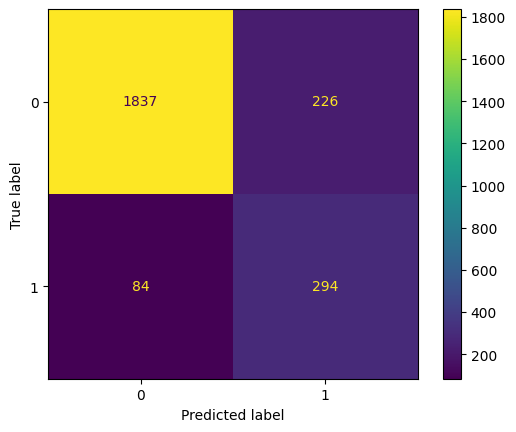

In [58]:
# Matriz de confusion
cm2= confusion_matrix(y_test, ranfor_optimo.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm2)
cm1_display.plot()
plt.show()

# Modelo 4: Gradient Boosting Classifier

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

gboos = GradientBoostingClassifier(
            n_estimators = 100,
            learning_rate= 0.1,
            max_depth = 4,
            random_state = 123
         )
gboos.fit(X_sub, y_sub)
#gboos.fit(X_train, y_train)


GradientBoostingClassifier(max_depth=4, random_state=123)

In [60]:
# Métricas de desempeño

print ("Train - Accuracy :", metrics.accuracy_score(y_train, gboos.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, gboos.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, gboos.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, gboos.predict(X_test)))

Train - Accuracy : 0.8814010651372388
Train - classification report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      8234
           1       0.59      0.81      0.68      1530

    accuracy                           0.88      9764
   macro avg       0.78      0.85      0.80      9764
weighted avg       0.90      0.88      0.89      9764

Test - Accuracy : 0.8816058992216305
Test - classification report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      2063
           1       0.59      0.78      0.67       378

    accuracy                           0.88      2441
   macro avg       0.77      0.84      0.80      2441
weighted avg       0.90      0.88      0.89      2441



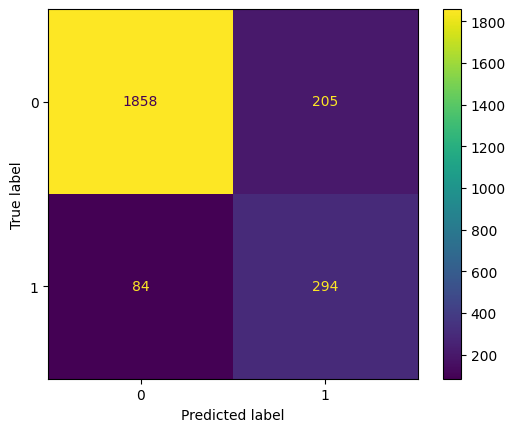

In [61]:
# Matriz de confusión

# Matriz de confusion
cm1= confusion_matrix(y_test, gboos.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

# Modelo 5: XGB Classifier

In [62]:
#%pip install xgboost
from xgboost import XGBClassifier


xgb = XGBClassifier(
    n_estimators = 100,
    learning_rate= 0.1,
    max_depth = 4,
    random_state = 123
)
xgb.fit(X_sub, y_sub)
#xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [63]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, xgb.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, xgb.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, xgb.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, xgb.predict(X_test)))

Train - Accuracy : 0.8777140516181893
Train - classification report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      8234
           1       0.58      0.81      0.67      1530

    accuracy                           0.88      9764
   macro avg       0.77      0.85      0.80      9764
weighted avg       0.90      0.88      0.89      9764

Test - Accuracy : 0.8770995493650143
Test - classification report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      2063
           1       0.58      0.77      0.66       378

    accuracy                           0.88      2441
   macro avg       0.77      0.83      0.79      2441
weighted avg       0.90      0.88      0.88      2441



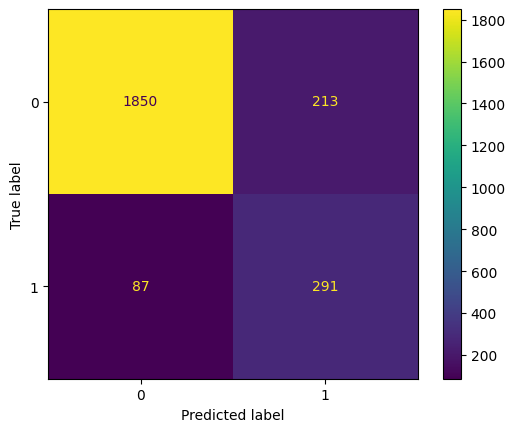

In [64]:
# Matriz de confusión

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm1= confusion_matrix(y_test, xgb.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()